# Cell 1: Setup and Imports

In [45]:
"""
ESP32 Camera + IMU Fusion Data Analysis
========================================
Visualizes synchronized IMU and camera data from ESP32 capture.
"""

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

# Better plot styling
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Libraries loaded")


✅ Libraries loaded


# Cell 2: Load Data

In [46]:
# Path to captured session
session_dir = Path("../data/test_capture")
frames_dir = session_dir / "frames"

# Load IMU data
imu_df = pd.read_csv(session_dir / "imu_data.csv")

# Convert timestamp to seconds for easier reading
imu_df['time_s'] = imu_df['timestamps_ms'] / 1000.0

# Get frame list
frame_files = sorted(frames_dir.glob("frame_*.jpg"))

print(f"📊 Loaded {len(imu_df)} IMU samples")
print(f"📸 Found {len(frame_files)} frames")
print(f"⏱️  Duration: {imu_df['time_s'].max():.1f} seconds")
print(f"\nFirst few IMU samples:")
imu_df.head()


📊 Loaded 1736 IMU samples
📸 Found 216 frames
⏱️  Duration: 4292.3 seconds

First few IMU samples:


,timestamps_ms,ax_raw,ay_raw,az_raw,gx_raw,gy_raw,gz_raw,time_s
0,4249127,-192,-776,17224,140,329,13,4249.127
1,4249137,-184,-804,17196,121,309,3,4249.137
2,4249147,-220,-824,17164,138,328,24,4249.147
3,4249157,-168,-836,17212,130,316,12,4249.157
4,4249167,-76,-860,17348,134,322,14,4249.167


# Cell3: Convert Raw Values to Physical Units

In [47]:
# Conversion constants
ACC_SCALE = 16384.0   # ±2g range
GYRO_SCALE = 131.0    # ±250°/s range

# Convert to physical units
imu_df['ax_g'] = imu_df['ax_raw'] / ACC_SCALE
imu_df['ay_g'] = imu_df['ay_raw'] / ACC_SCALE
imu_df['az_g'] = imu_df['az_raw'] / ACC_SCALE

imu_df['gx_dps'] = imu_df['gx_raw'] / GYRO_SCALE
imu_df['gy_dps'] = imu_df['gy_raw'] / GYRO_SCALE
imu_df['gz_dps'] = imu_df['gz_raw'] / GYRO_SCALE

print("✅ Converted raw values to physical units (g and °/s)")
imu_df[['time_s', 'ax_g', 'ay_g', 'az_g', 'gx_dps', 'gy_dps', 'gz_dps']].head()


✅ Converted raw values to physical units (g and °/s)


,time_s,ax_g,ay_g,az_g,gx_dps,gy_dps,gz_dps
0,4249.127,-0.011719,-0.047363,1.051270,1.068702,2.511450,0.099237
1,4249.137,-0.011230,-0.049072,1.049561,0.923664,2.358779,0.022901
2,4249.147,-0.013428,-0.050293,1.047607,1.053435,2.503817,0.183206
3,4249.157,-0.010254,-0.051025,1.050537,0.992366,2.412214,0.091603
4,4249.167,-0.004639,-0.052490,1.058838,1.022901,2.458015,0.106870


# Cell 4: Plot Acceleration Over Time

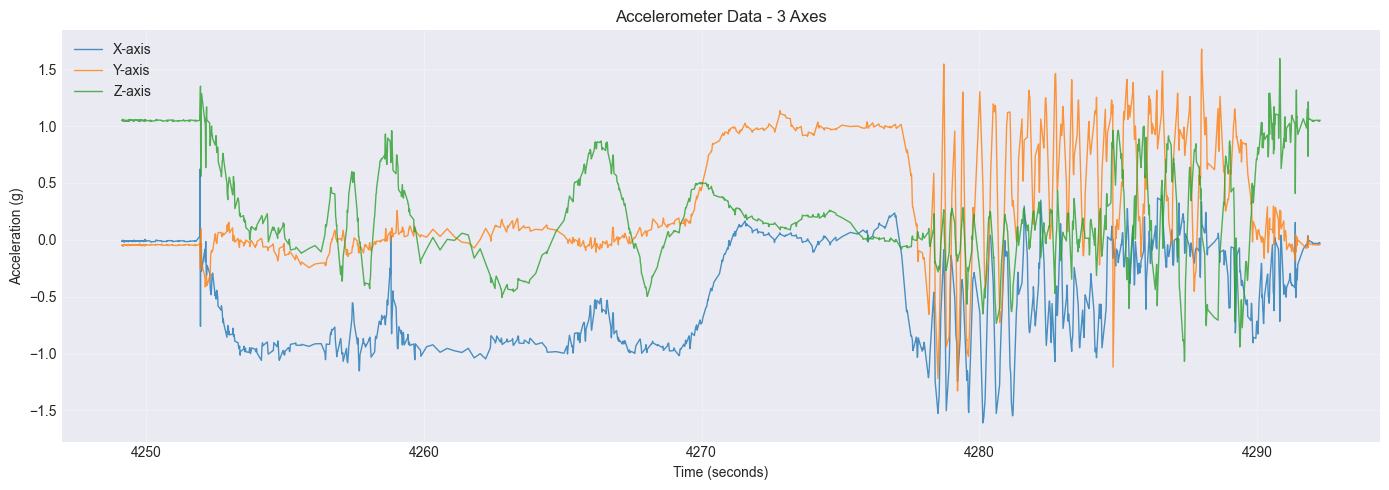

📊 Z-axis should hover around 1g when device is flat (gravity)


In [48]:
# Plot accelerometer data
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(imu_df['time_s'], imu_df['ax_g'], label='X-axis', linewidth=1, alpha=0.8)
ax.plot(imu_df['time_s'], imu_df['ay_g'], label='Y-axis', linewidth=1, alpha=0.8)
ax.plot(imu_df['time_s'], imu_df['az_g'], label='Z-axis', linewidth=1, alpha=0.8)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Acceleration (g)')
ax.set_title('Accelerometer Data - 3 Axes')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Z-axis should hover around 1g when device is flat (gravity)")


# Cell 5: Plot Gyroscope Over Time

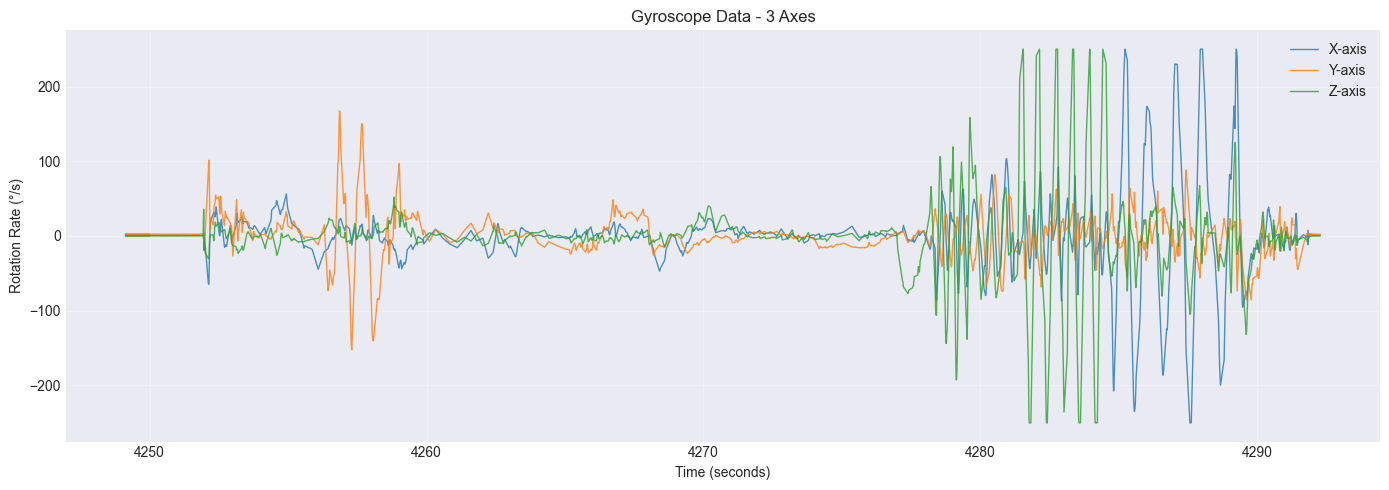

📊 Should be near 0°/s when stationary, spikes when rotating


In [49]:
# Plot gyroscope data
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(imu_df['time_s'], imu_df['gx_dps'], label='X-axis', linewidth=1, alpha=0.8)
ax.plot(imu_df['time_s'], imu_df['gy_dps'], label='Y-axis', linewidth=1, alpha=0.8)
ax.plot(imu_df['time_s'], imu_df['gz_dps'], label='Z-axis', linewidth=1, alpha=0.8)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Rotation Rate (°/s)')
ax.set_title('Gyroscope Data - 3 Axes')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Should be near 0°/s when stationary, spikes when rotating")


# Cell 6: Function to Display Frame at Specific Time

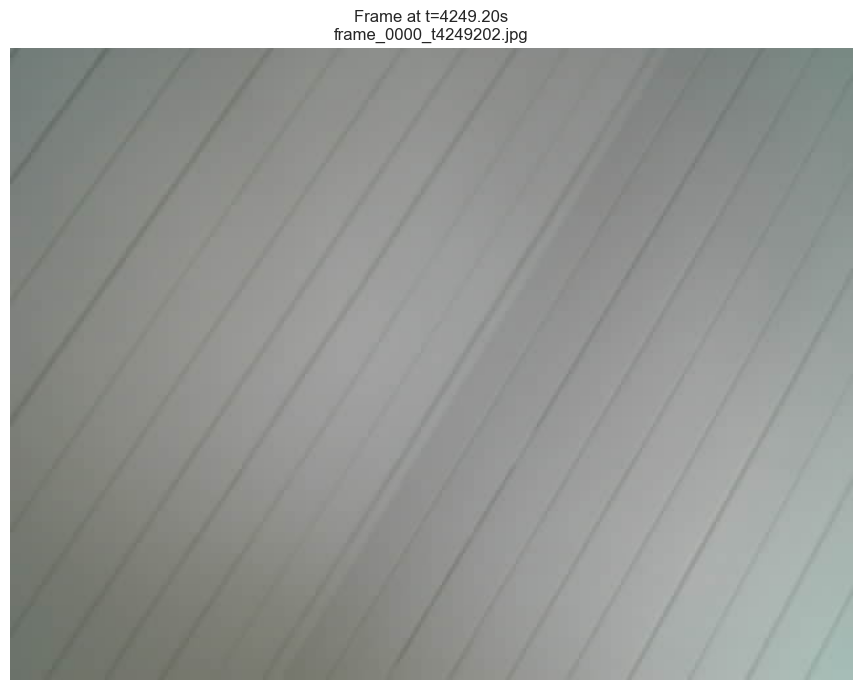

📸 Showing frame from t=4249.20s (requested: 10.00s)


In [50]:
def show_frame_at_time(target_time_s):
    """Display the camera frame closest to the given time"""
    
    # Find frame closest to target time
    best_frame = None
    best_diff = float('inf')
    
    for frame_path in frame_files:
        # Extract timestamp from filename: frame_0000_t7399.jpg
        parts = frame_path.stem.split('_t')
        if len(parts) == 2:
            frame_time_ms = int(parts[1])
            frame_time_s = frame_time_ms / 1000.0
            
            diff = abs(frame_time_s - target_time_s)
            if diff < best_diff:
                best_diff = diff
                best_frame = (frame_path, frame_time_s)
    
    if best_frame:
        frame_path, frame_time_s = best_frame
        img = Image.open(frame_path)
        
        plt.figure(figsize=(10, 7))
        plt.imshow(img)
        plt.title(f'Frame at t={frame_time_s:.2f}s\n{frame_path.name}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"📸 Showing frame from t={frame_time_s:.2f}s (requested: {target_time_s:.2f}s)")
    else:
        print("❌ No frame found")

# Test: Show a frame from around 10 seconds
show_frame_at_time(10.0)


# Cell 7: Extract Frame Timestamps

In [51]:
# Extract all frame timestamps for plotting
frame_times_s = []

for frame_path in frame_files:
    parts = frame_path.stem.split('_t')
    if len(parts) == 2:
        frame_time_ms = int(parts[1])
        frame_times_s.append(frame_time_ms / 1000.0)

frame_times_s = sorted(frame_times_s)

print(f"📸 Extracted {len(frame_times_s)} frame timestamps")
print(f"First frame: {frame_times_s[0]:.2f}s")
print(f"Last frame: {frame_times_s[-1]:.2f}s")


📸 Extracted 216 frame timestamps
First frame: 4249.20s
Last frame: 4292.07s


# Cell 8: Combined Plot - IMU with Frame Markers

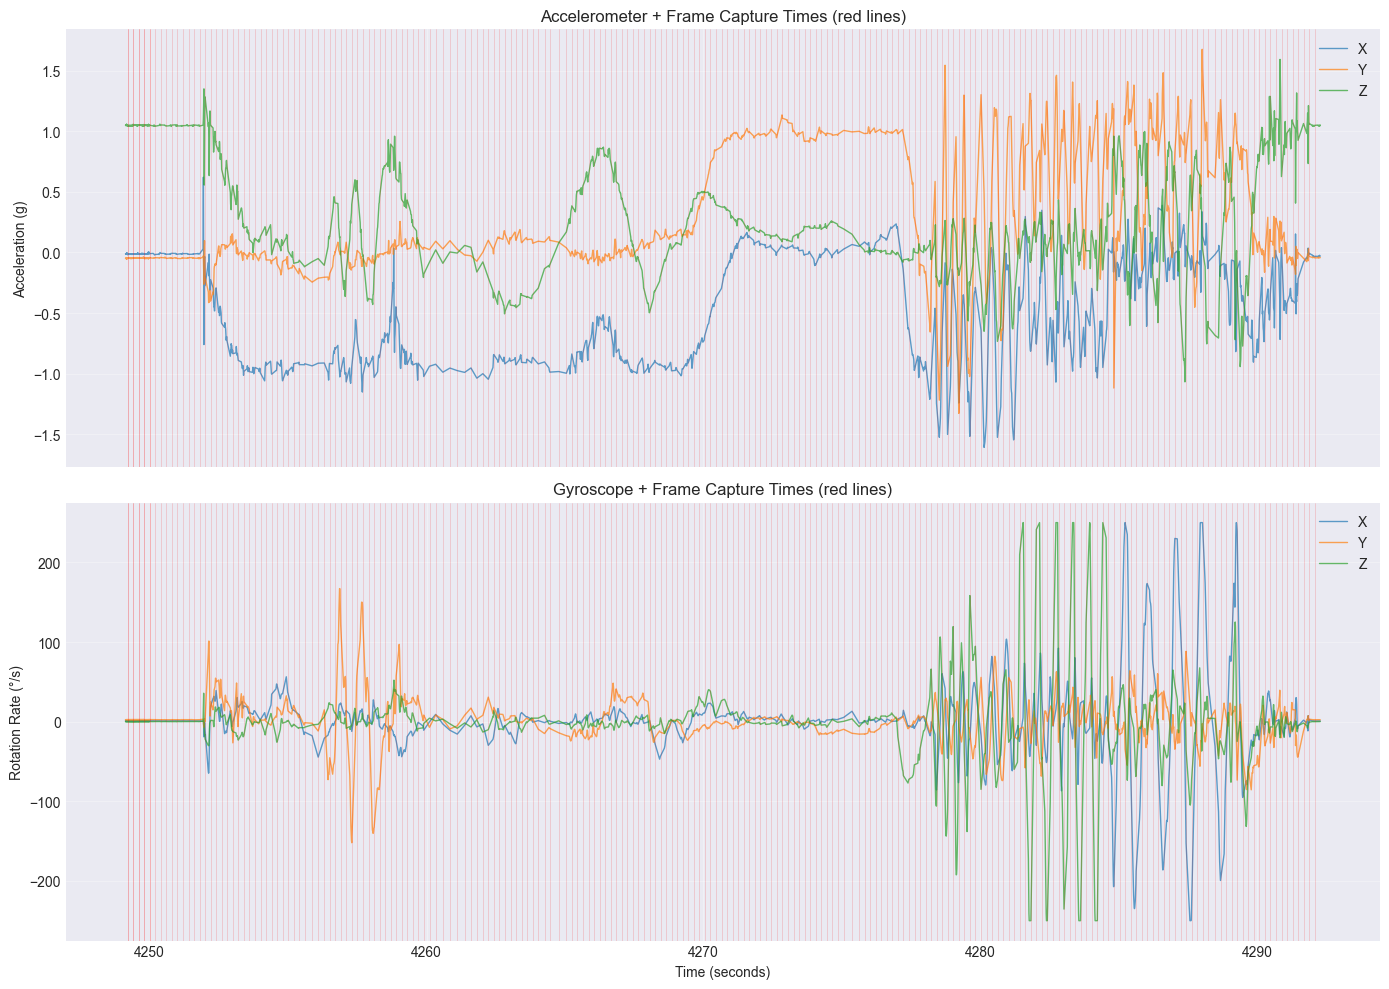

📊 Red vertical lines show when camera frames were captured
📸 Notice IMU gaps align with frame times (camera blocks IMU sampling)


In [52]:
# Create combined visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Acceleration
ax1.plot(imu_df['time_s'], imu_df['ax_g'], label='X', linewidth=1, alpha=0.7)
ax1.plot(imu_df['time_s'], imu_df['ay_g'], label='Y', linewidth=1, alpha=0.7)
ax1.plot(imu_df['time_s'], imu_df['az_g'], label='Z', linewidth=1, alpha=0.7)

# Mark when frames were captured
for ft in frame_times_s:
    ax1.axvline(ft, color='red', alpha=0.2, linewidth=0.5)

ax1.set_ylabel('Acceleration (g)')
ax1.set_title('Accelerometer + Frame Capture Times (red lines)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Gyroscope
ax2.plot(imu_df['time_s'], imu_df['gx_dps'], label='X', linewidth=1, alpha=0.7)
ax2.plot(imu_df['time_s'], imu_df['gy_dps'], label='Y', linewidth=1, alpha=0.7)
ax2.plot(imu_df['time_s'], imu_df['gz_dps'], label='Z', linewidth=1, alpha=0.7)

# Mark when frames were captured
for ft in frame_times_s:
    ax2.axvline(ft, color='red', alpha=0.2, linewidth=0.5)

ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Rotation Rate (°/s)')
ax2.set_title('Gyroscope + Frame Capture Times (red lines)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Red vertical lines show when camera frames were captured")
print(f"📸 Notice IMU gaps align with frame times (camera blocks IMU sampling)")


# Cell 9: Create Highlight Reel

🎬 Creating highlight reel...


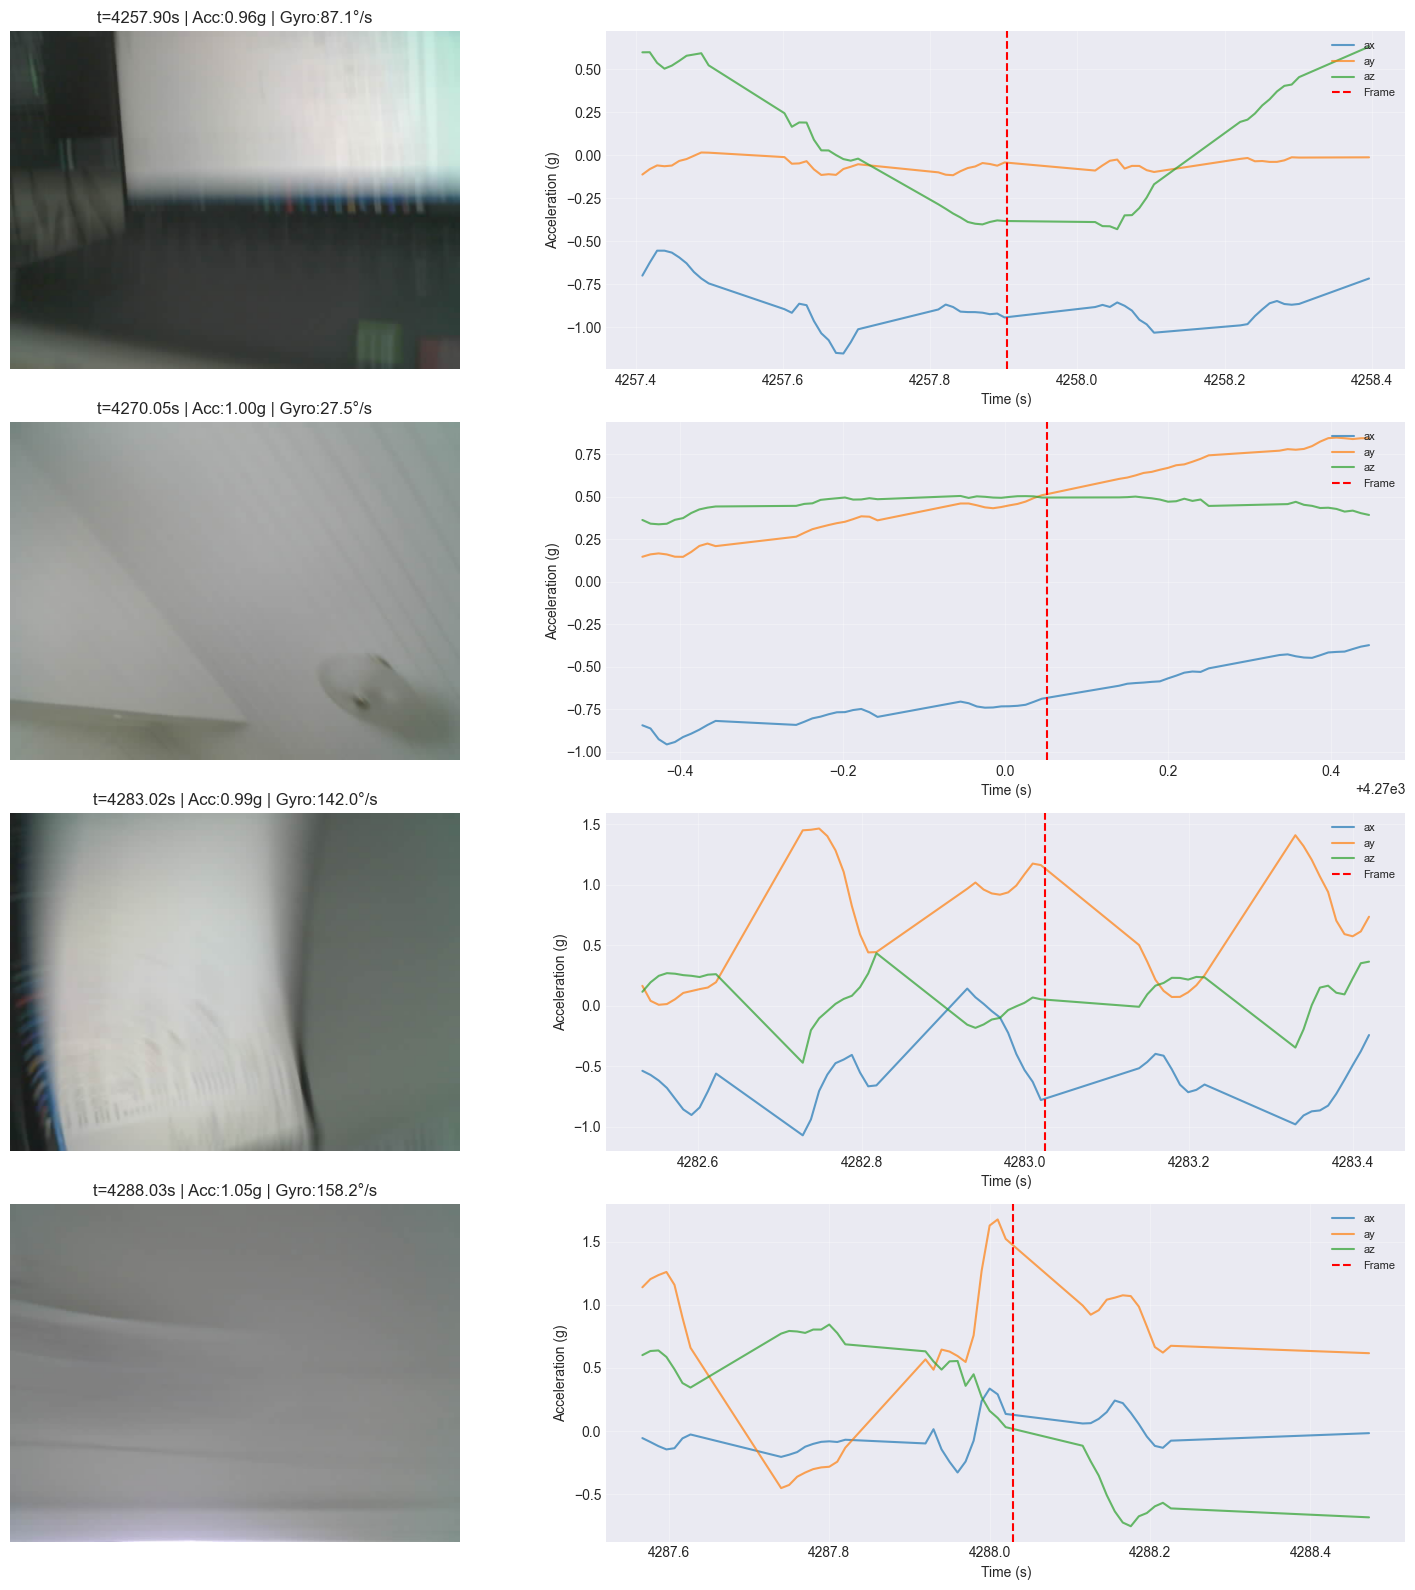

In [53]:
# Create a highlight reel: show frames at key timestamps
def create_highlight_reel(times_to_show):
    """
    Display multiple frames with IMU data context
    
    Args:
        times_to_show: list of timestamps in seconds
    """
    n_frames = len(times_to_show)
    fig = plt.figure(figsize=(16, n_frames * 4))
    
    for idx, target_time_s in enumerate(times_to_show):
        # Find closest frame
        best_frame = None
        best_diff = float('inf')
        
        for frame_path in frame_files:
            parts = frame_path.stem.split('_t')
            if len(parts) == 2:
                frame_time_ms = int(parts[1])
                frame_time_s = frame_time_ms / 1000.0
                diff = abs(frame_time_s - target_time_s)
                if diff < best_diff:
                    best_diff = diff
                    best_frame = (frame_path, frame_time_s)
        
        if best_frame:
            frame_path, frame_time_s = best_frame
            
            # Get IMU data near this time (±0.5s window)
            imu_window = imu_df[
                (imu_df['time_s'] >= frame_time_s - 0.5) & 
                (imu_df['time_s'] <= frame_time_s + 0.5)
            ]
            
            # Calculate statistics
            avg_acc = np.sqrt(imu_window['ax_g']**2 + 
                            imu_window['ay_g']**2 + 
                            imu_window['az_g']**2).mean()
            avg_gyro = np.sqrt(imu_window['gx_dps']**2 + 
                             imu_window['gy_dps']**2 + 
                             imu_window['gz_dps']**2).mean()
            
            # Load image
            img = Image.open(frame_path)
            
            # Create subplot: image on left, IMU on right
            ax_img = plt.subplot(n_frames, 2, idx*2 + 1)
            ax_img.imshow(img)
            ax_img.set_title(f't={frame_time_s:.2f}s | Acc:{avg_acc:.2f}g | Gyro:{avg_gyro:.1f}°/s')
            ax_img.axis('off')
            
            # Plot IMU window
            ax_imu = plt.subplot(n_frames, 2, idx*2 + 2)
            ax_imu.plot(imu_window['time_s'], imu_window['ax_g'], label='ax', alpha=0.7)
            ax_imu.plot(imu_window['time_s'], imu_window['ay_g'], label='ay', alpha=0.7)
            ax_imu.plot(imu_window['time_s'], imu_window['az_g'], label='az', alpha=0.7)
            ax_imu.axvline(frame_time_s, color='red', linestyle='--', label='Frame')
            ax_imu.set_xlabel('Time (s)')
            ax_imu.set_ylabel('Acceleration (g)')
            ax_imu.legend(loc='upper right', fontsize=8)
            ax_imu.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Select interesting moments from your capture
# Pick times where something interesting happened
highlight_times = [4258, 4270, 4283,4288]  # Adjust based on your movements

print("🎬 Creating highlight reel...")
create_highlight_reel(highlight_times)


# Cell 10: Summary Statistics

In [54]:
# Calculate and display summary statistics
print("="*60)
print("📊 SESSION SUMMARY")
print("="*60)

duration_s = imu_df['time_s'].max() - imu_df['time_s'].min()
print(f"Duration:           {duration_s:.1f} seconds")
print(f"IMU samples:        {len(imu_df)}")
print(f"Frames captured:    {len(frame_files)}")
print(f"Avg IMU rate:       {len(imu_df)/duration_s:.1f} Hz")
print(f"Avg frame rate:     {len(frame_files)/duration_s:.2f} fps")

print(f"\n--- Accelerometer Range ---")
print(f"X: {imu_df['ax_g'].min():.2f}g to {imu_df['ax_g'].max():.2f}g")
print(f"Y: {imu_df['ay_g'].min():.2f}g to {imu_df['ay_g'].max():.2f}g")
print(f"Z: {imu_df['az_g'].min():.2f}g to {imu_df['az_g'].max():.2f}g")

print(f"\n--- Gyroscope Range ---")
print(f"X: {imu_df['gx_dps'].min():.1f}°/s to {imu_df['gx_dps'].max():.1f}°/s")
print(f"Y: {imu_df['gy_dps'].min():.1f}°/s to {imu_df['gy_dps'].max():.1f}°/s")
print(f"Z: {imu_df['gz_dps'].min():.1f}°/s to {imu_df['gz_dps'].max():.1f}°/s")

print("="*60)


📊 SESSION SUMMARY
Duration:           43.1 seconds
IMU samples:        1736
Frames captured:    216
Avg IMU rate:       40.2 Hz
Avg frame rate:     5.01 fps

--- Accelerometer Range ---
X: -1.61g to 0.62g
Y: -1.33g to 1.68g
Z: -1.07g to 1.59g

--- Gyroscope Range ---
X: -250.1°/s to 250.1°/s
Y: -152.2°/s to 167.2°/s
Z: -250.1°/s to 250.1°/s
